# Pet Emotion Detection 

**Problem Statement:**   
This project aims to build a model to know the emotion of a pet by their facial expression. Understanding the emotional states of pets is crucial for enhancing human-pet interactions and ensuring their well-being. Traditional methods for interpreting pet emotions have limitations, necessitating the application of machine learning and computer vision techniques to predict pet facial expressions accurately.

**Objective:**   
The main objective of this project is to develop a pet facial expression prediction system using neural networks (CNN). The system will be designed to classify pet facial images into different emotional states, such as happiness, sadness, angry, and others, providing valuable insights into pets' emotional well-being. Aditionally, we will try to see the changes in accuray in this model by using different optimizers.

**Dataset:**  
For this project, I've selected a dataset from Kaggle "Pet's Facial Expression Image Dataset" by Ansh Tanwar [[[https://www.kaggle.com/datasets/anshtanwar/pets-facial-expression-dataset](https://www.kaggle.com/datasets/anshtanwar/pets-facial-expression-dataset)]]. 
While this dataset is new, we will take this as a reference and explore the project and see if we can make tweaks or improvements to it. the dataset has train, test and validation data that are classified into various pet's emotions.  


In [1]:
import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from tensorflow import keras
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
# code to make tensors run on GPU
def set_gpu_device():
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Calling the function to set GPU device
set_gpu_device()
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("No GPU found. TensorFlow will use the CPU.")

GPU is available!


In [3]:
# seting path to the dataset
train_data = pathlib.Path('pet/Data/train/')
test_data = pathlib.Path('pet/Data/test/')
valid_data = pathlib.Path('pet/Data/valid/')


#### Exploring various emotions of our dataset:

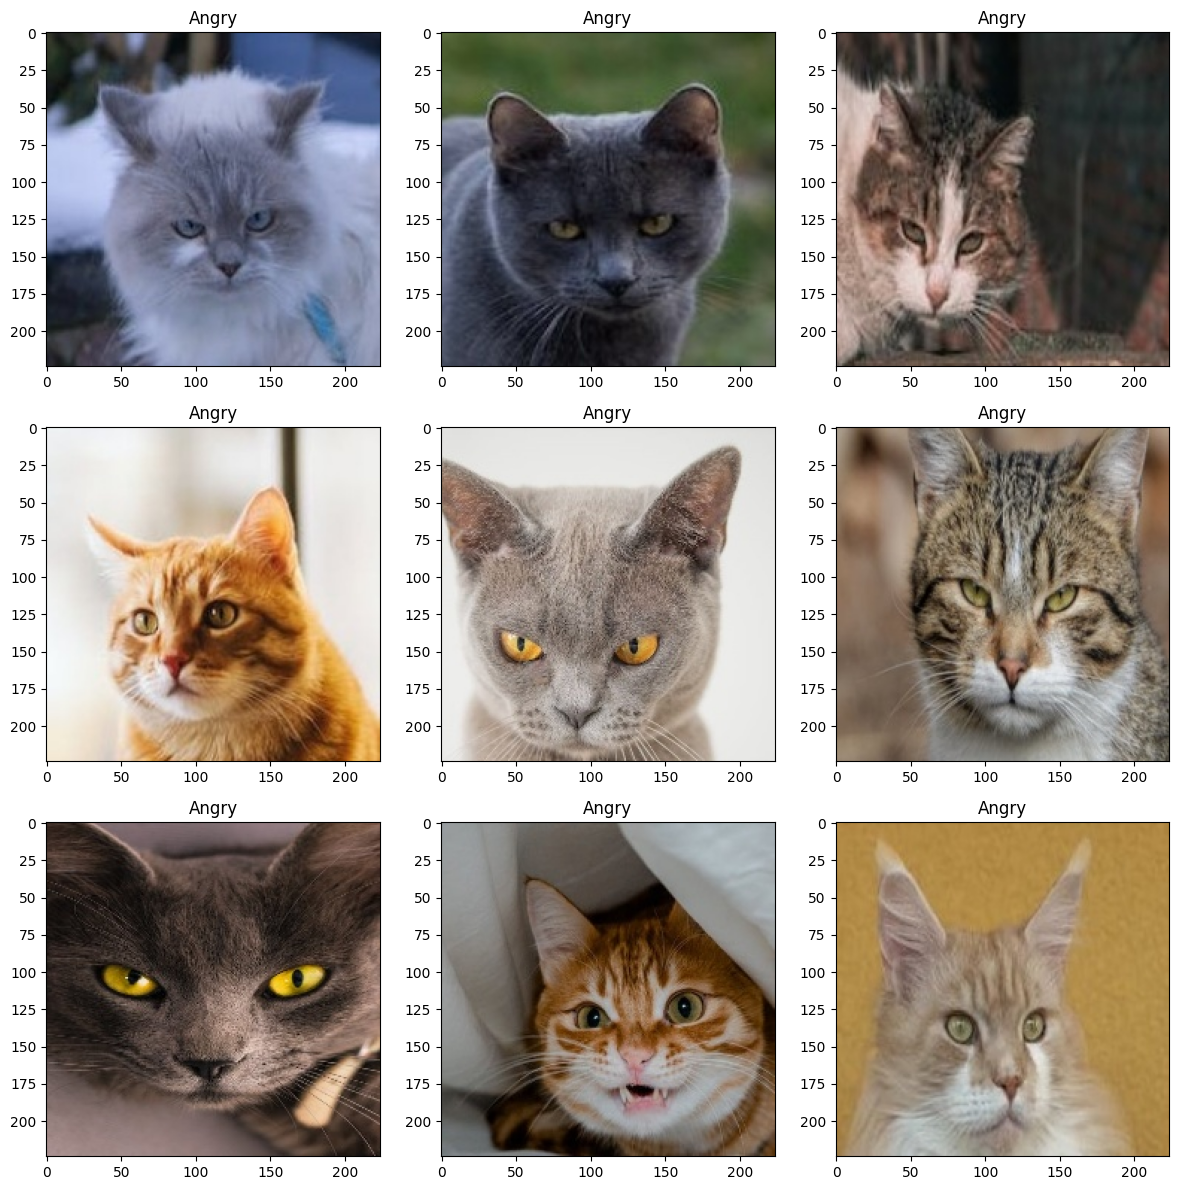

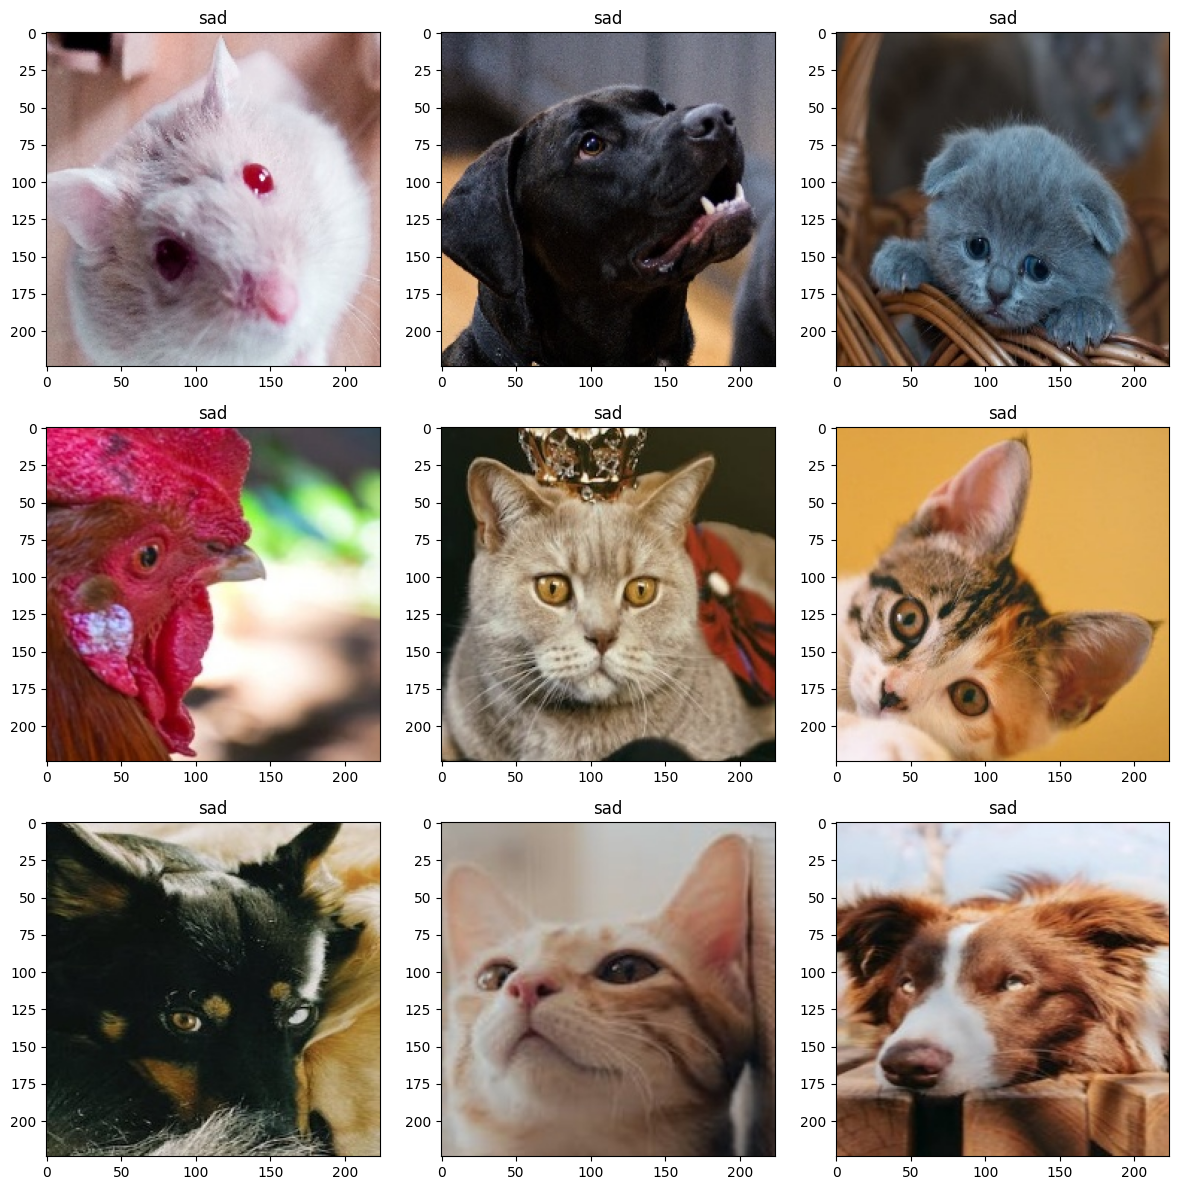

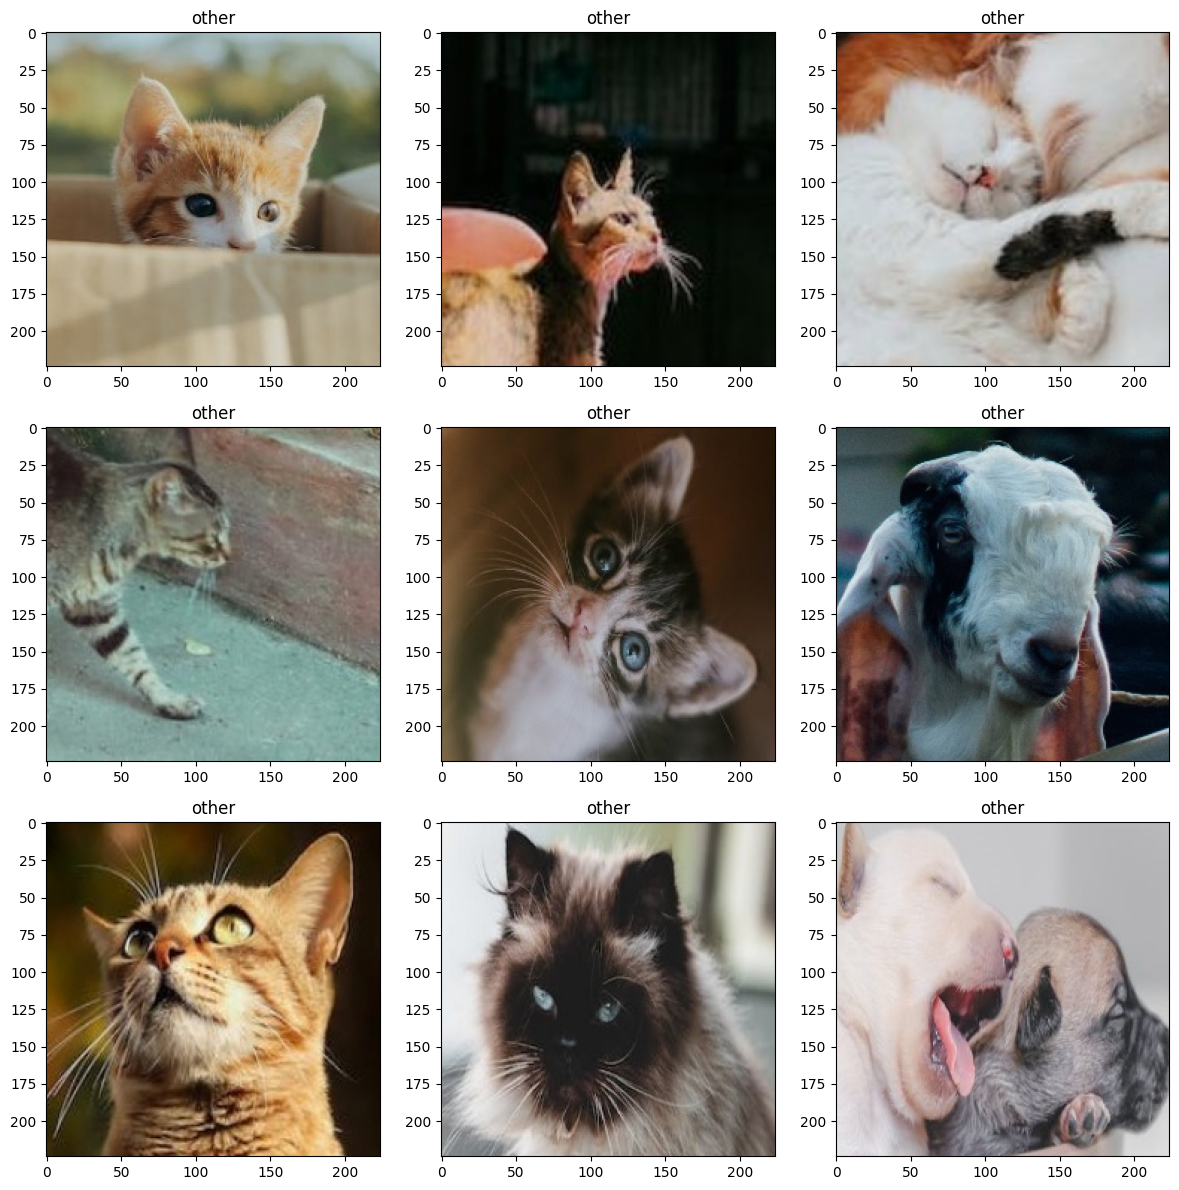

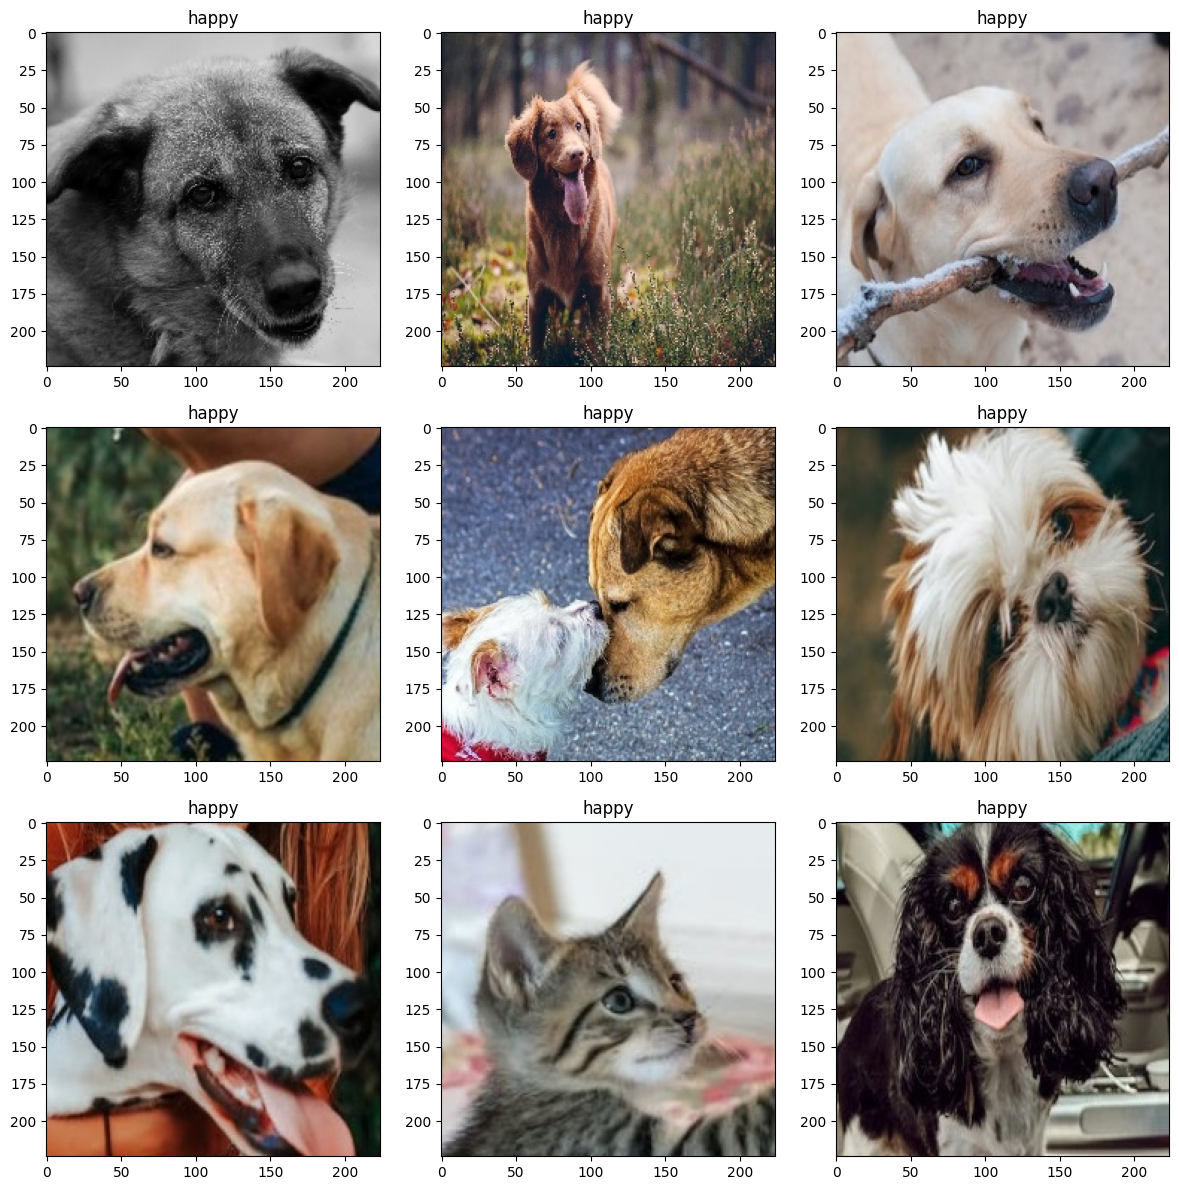

In [4]:
from tensorflow.keras.preprocessing.image import load_img
path = "pet/Data/train/"
expression = ['Angry', 'sad', 'other', 'happy']
for exp in expression:
    plt.figure(figsize=(12, 12))
    for i in range(1, 10, 1):
        plt.subplot(3, 3, i)
        img = load_img(path + exp + "/" +
                       os.listdir(path + exp)[i], target_size=(224, 224))
        plt.imshow(img) 
        plt.title(exp)  
    plt.tight_layout()  
    plt.show()

Data Preprocessing:

- Data augmentation is done to increase the variation in our training data, which helps the model generalize better on unseen examples. 
- In our code we applied some random rotations, shifts, and flips, simulating real-world cases that might occour when capturing an image of a pet.

#### Data Augmentation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# batch size and target image size
batch_size = 32
# img_size = (224, 224) 
img_size = (128, 128) 

# It is used to generate augmented images for training  model.
train_datagen = ImageDataGenerator(
    rotation_range=20,
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip=True,
)

datagen = ImageDataGenerator()


train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical' 
)

valid_generator = datagen.flow_from_directory(
    valid_data,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_data,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1000 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


##### Image after augumentation:

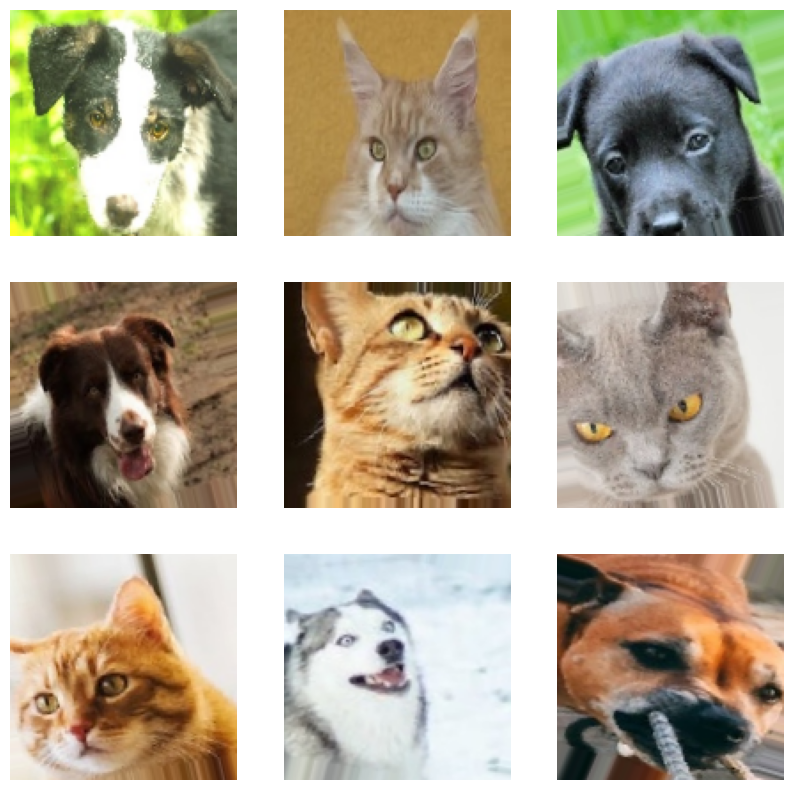

In [18]:
# generating a batch of images from a `train_generator` and displaying them in a 3x3 grid.

images, _ = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.axis("off")
plt.show()

##### Simple model:

In [19]:

# creaing a sequential model
model = Sequential()

# adding convolutional and pooling layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# model head
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(4, activation='softmax'))  # 4 represents the number of classes in our case the emotions


model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 128)     

In [28]:
# setting training steps per epoch
# to ensure the enteri dataset is covered in in on epoch
# model trains on the entire training dataset and validates on the entire validation dataset while effectively utilizing available memory and computational resources.
# steps_per_epoch = train_generator.samples // batch_size
# validation_steps = valid_generator.samples // batch_size

# compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="data/pet_models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
# model fitting/ training
history = model.fit(
    train_generator,
    # steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=valid_generator,
    # validation_steps=validation_steps,
    callbacks = callbacks
)

Epoch 1/20
32/32 [==============================] - 6s 179ms/step - loss: 0.8223 - accuracy: 0.6560 - val_loss: 3.0292 - val_accuracy: 0.3333
Epoch 2/20
32/32 [==============================] - 4s 116ms/step - loss: 0.8069 - accuracy: 0.6710 - val_loss: 3.2253 - val_accuracy: 0.3611
Epoch 3/20
32/32 [==============================] - 5s 158ms/step - loss: 0.7488 - accuracy: 0.6890 - val_loss: 2.5385 - val_accuracy: 0.2778
Epoch 4/20
32/32 [==============================] - 4s 113ms/step - loss: 0.7498 - accuracy: 0.6940 - val_loss: 2.9510 - val_accuracy: 0.2778
Epoch 5/20
32/32 [==============================] - 4s 113ms/step - loss: 0.7609 - accuracy: 0.7000 - val_loss: 2.8884 - val_accuracy: 0.3056
Epoch 6/20
32/32 [==============================] - 4s 113ms/step - loss: 0.7386 - accuracy: 0.6920 - val_loss: 3.4021 - val_accuracy: 0.2500
Epoch 7/20
32/32 [==============================] - 4s 113ms/step - loss: 0.7404 - accuracy: 0.6970 - val_loss: 3.4245 - val_accuracy: 0.3333
Epoch 

##### Perfomance of model:

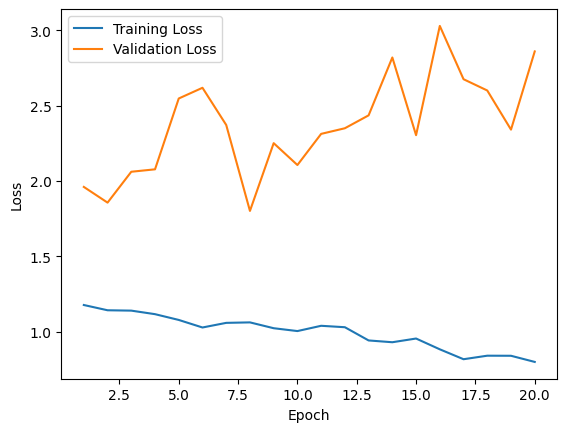

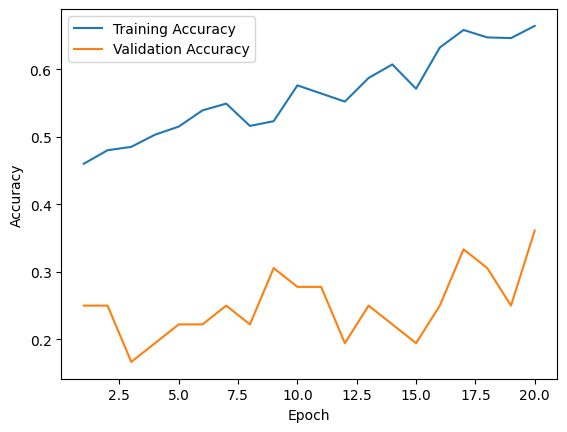

In [25]:
# Accessing performance metrics from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Assuming you have the same number of epochs as in your training
epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


##### Perfomance Metrics:

In [26]:
# evaluating the performance of the model on a test dataset.
test_loss, test_acc = model.evaluate(test_generator)
val_loss, val_acc = model.evaluate(valid_generator)
print(f"Test accuracy: {test_acc*100:.2f}%")
print(f"Validation accuracy: {val_acc*100:.2f}%")


2/2 [==============================] - 0s 6ms/step - loss: 2.8609 - accuracy: 0.3611
Test accuracy: 31.58%
Validation accuracy: 36.11%


In [27]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
y_pred = model.predict(test_generator)
y_predict =  np.argmax(y_pred, axis =1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true,y_predict)
class_report = classification_report(y_true, y_predict, target_names=test_generator.class_indices.keys())
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


2/2 [==============================] - 0s 8ms/step
Confusion Matrix:
 [[2 2 2 4]
 [1 3 0 2]
 [4 2 4 1]
 [2 4 2 3]]

Classification Report:
               precision    recall  f1-score   support

       Angry       0.22      0.20      0.21        10
       Other       0.27      0.50      0.35         6
         Sad       0.50      0.36      0.42        11
       happy       0.30      0.27      0.29        11

    accuracy                           0.32        38
   macro avg       0.32      0.33      0.32        38
weighted avg       0.33      0.32      0.32        38



##### Experimenting with optimizer : 

In [ ]:
from tensorflow.keras import regularizers



def build_model(seed=23, input_shape=(128, 128, 3), num_classes=4):
    tf.random.set_seed(seed)
    
    model = Sequential()
    # Convolutional and pooling layers
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPooling2D(2, 2))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# def build_model(seed=23):
#     tf.random.set_seed(seed)
#     # Creating a deeper sequential model
#     model = Sequential()

#     # Adding convolutional and pooling layers
#     model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(224, 224, 3)))
#     model.add(MaxPooling2D(2, 2))

#     model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
#     model.add(MaxPooling2D(2, 2))

#     model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
#     model.add(MaxPooling2D(2, 2))

#     model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
#     model.add(MaxPooling2D(2, 2))

#     model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
#     model.add(MaxPooling2D(2, 2))

#     # Model head
#     model.add(Flatten())
#     model.add(Dense(1024, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
#     model.add(Dropout(0.5))
#     model.add(Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
#     model.add(Dropout(0.5))
#     model.add(Dense(4, activation='softmax'))
#     return model

def build_simple_model(seed=23):
    tf.random.set_seed(seed)
    # Creating a simpler sequential model
    model = Sequential()

    # Adding convolutional and pooling layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(124, 124, 3)))
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(2, 2))

    # Model head
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

    return model


In [ ]:
def build_and_train_model(optimizer, name):
    
    model = build_model()
    # model = build_simple_model()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="data/pet_models/"+name+".keras",
        save_best_only=True,
        monitor="val_loss")]

    return model.fit(train_generator,
                epochs=20,
                validation_data=valid_generator,
                callbacks = callbacks,
                verbose = 1
                )


# def build_and_train_model(optimizer, name):
    
#     steps_per_epoch = train_generator.samples // batch_size
#     validation_steps = valid_generator.samples // batch_size

#     model = build_model()
#     # model = build_simple_model()
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#     callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         filepath="data/pet_models/fine_tuning_"+name+".keras",
#         save_best_only=True,
#         monitor="val_loss")]

#     return model.fit(train_generator,
#                 steps_per_epoch=steps_per_epoch,
#                 epochs=20,
#                 validation_data=valid_generator,
#                 validation_steps=validation_steps,
#                 callbacks = callbacks)


In [ ]:
lr = 0.001 # setting learning rate

##### Adagrad Optimizer:

Epoch 1/20
32/32 [==============================] - 8s 196ms/step - loss: 358.3520 - accuracy: 0.2540 - val_loss: 51.5067 - val_accuracy: 0.2222
Epoch 2/20
32/32 [==============================] - 6s 176ms/step - loss: 52.8896 - accuracy: 0.2730 - val_loss: 50.4415 - val_accuracy: 0.3056
Epoch 3/20
32/32 [==============================] - 6s 186ms/step - loss: 51.3047 - accuracy: 0.2620 - val_loss: 50.3485 - val_accuracy: 0.1667
Epoch 4/20
32/32 [==============================] - 6s 181ms/step - loss: 50.6187 - accuracy: 0.2910 - val_loss: 50.0856 - val_accuracy: 0.2500
Epoch 5/20
32/32 [==============================] - 6s 174ms/step - loss: 50.4342 - accuracy: 0.2700 - val_loss: 49.9790 - val_accuracy: 0.2222
Epoch 6/20
32/32 [==============================] - 6s 181ms/step - loss: 50.2268 - accuracy: 0.2790 - val_loss: 49.8465 - val_accuracy: 0.2778
Epoch 7/20
32/32 [==============================] - 6s 183ms/step - loss: 49.9665 - accuracy: 0.2780 - val_loss: 49.7004 - val_accuracy

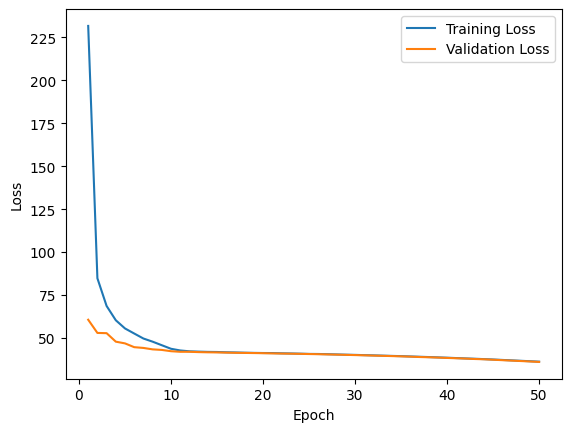

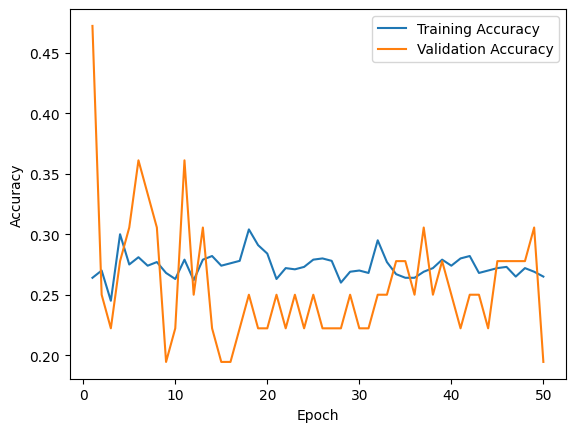

2/2 [==============================] - 0s 7ms/step - loss: 48.5563 - accuracy: 0.3056
Test accuracy: 31.58%
Validation accuracy: 30.56%


In [ ]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr)

history_adagrad = build_and_train_model(optimizer, name = "adagrad")

# Accessing performance metrics from history
train_loss = history_adamax.history['loss']
val_loss = history_adamax.history['val_loss']
train_acc = history_adamax.history['accuracy']
val_acc = history_adamax.history['val_accuracy']

# Assuming you have the same number of epochs as in your training
epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
model_adamx = keras.models.load_model("data/pet_models/adagrad.keras")

# Evaluate the model on the test and validation datasets
test_loss, test_acc = model_adamx.evaluate(test_generator)
val_loss, val_acc = model_adamx.evaluate(valid_generator)
print(f"Test accuracy: {test_acc*100:.2f}%")
print(f"Validation accuracy: {val_acc*100:.2f}%")


##### RMSprop Optimizer:

Epoch 1/20
32/32 [==============================] - 7s 200ms/step - loss: 1000.4576 - accuracy: 0.2560 - val_loss: 39.2072 - val_accuracy: 0.2778
Epoch 2/20
32/32 [==============================] - 4s 121ms/step - loss: 45.3329 - accuracy: 0.2730 - val_loss: 281.1938 - val_accuracy: 0.1667
Epoch 3/20
32/32 [==============================] - 6s 177ms/step - loss: 46.2986 - accuracy: 0.2690 - val_loss: 29.7008 - val_accuracy: 0.3056
Epoch 4/20
32/32 [==============================] - 4s 124ms/step - loss: 30.8383 - accuracy: 0.2600 - val_loss: 37.0610 - val_accuracy: 0.3056
Epoch 5/20
32/32 [==============================] - 6s 182ms/step - loss: 19.9634 - accuracy: 0.2540 - val_loss: 16.5363 - val_accuracy: 0.1667
Epoch 6/20
32/32 [==============================] - 6s 179ms/step - loss: 13.2346 - accuracy: 0.2330 - val_loss: 10.2787 - val_accuracy: 0.3056
Epoch 7/20
32/32 [==============================] - 6s 174ms/step - loss: 8.3188 - accuracy: 0.2460 - val_loss: 6.1704 - val_accuracy

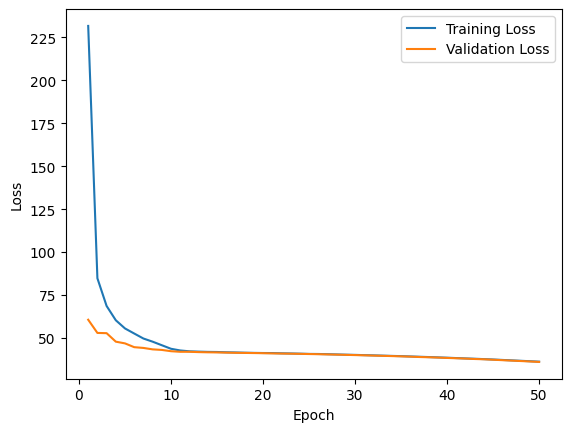

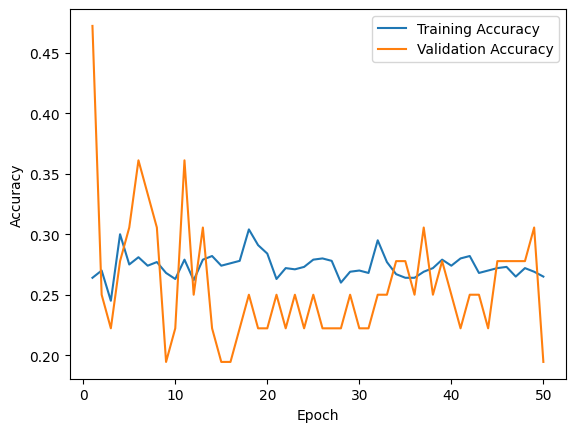

2/2 [==============================] - 0s 7ms/step - loss: 1.4363 - accuracy: 0.2500
Test accuracy: 26.32%
Validation accuracy: 25.00%


In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr, rho=0.9)

history_rmsprop = build_and_train_model(optimizer, name= "rmsprop")

# Accessing performance metrics from history
train_loss = history_adamax.history['loss']
val_loss = history_adamax.history['val_loss']
train_acc = history_adamax.history['accuracy']
val_acc = history_adamax.history['val_accuracy']

# Assuming you have the same number of epochs as in your training
epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model_adamx = keras.models.load_model("data/pet_models/rmsprop.keras")

# Evaluate the model on the test and validation datasets
test_loss, test_acc = model_adamx.evaluate(test_generator)
val_loss, val_acc = model_adamx.evaluate(valid_generator)
print(f"Test accuracy: {test_acc*100:.2f}%")
print(f"Validation accuracy: {val_acc*100:.2f}%")

##### Adam Optimizer:

Epoch 1/20
32/32 [==============================] - 7s 211ms/step - loss: 321.4827 - accuracy: 0.2780 - val_loss: 43.2591 - val_accuracy: 0.2500
Epoch 2/20
32/32 [==============================] - 7s 219ms/step - loss: 42.2792 - accuracy: 0.2990 - val_loss: 41.2372 - val_accuracy: 0.2778
Epoch 3/20
32/32 [==============================] - 6s 201ms/step - loss: 40.4180 - accuracy: 0.2950 - val_loss: 39.5952 - val_accuracy: 0.2778
Epoch 4/20
32/32 [==============================] - 8s 243ms/step - loss: 38.8678 - accuracy: 0.2910 - val_loss: 38.1628 - val_accuracy: 0.2500
Epoch 5/20
32/32 [==============================] - 9s 279ms/step - loss: 37.5620 - accuracy: 0.2870 - val_loss: 37.0290 - val_accuracy: 0.3889
Epoch 6/20
32/32 [==============================] - 7s 211ms/step - loss: 36.3939 - accuracy: 0.3060 - val_loss: 35.8577 - val_accuracy: 0.2500
Epoch 7/20
32/32 [==============================] - 8s 256ms/step - loss: 35.3475 - accuracy: 0.2860 - val_loss: 34.8000 - val_accuracy

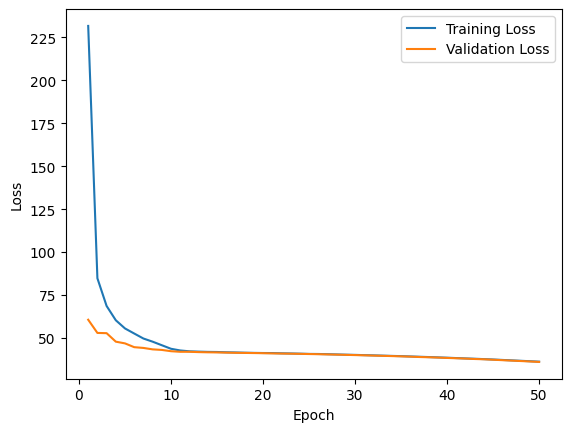

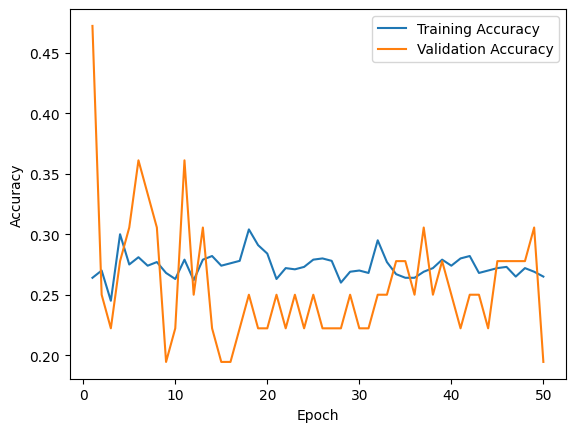

2/2 [==============================] - 0s 8ms/step - loss: 26.2289 - accuracy: 0.3333
Test accuracy: 21.05%
Validation accuracy: 33.33%


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9,
                                     beta_2=0.999)

history_adam = build_and_train_model(optimizer, name = "adam")
# Accessing performance metrics from history
train_loss = history_adamax.history['loss']
val_loss = history_adamax.history['val_loss']
train_acc = history_adamax.history['accuracy']
val_acc = history_adamax.history['val_accuracy']

# Assuming you have the same number of epochs as in your training
epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model_adamx = keras.models.load_model("data/pet_models/adam.keras")

# Evaluate the model on the test and validation datasets
test_loss, test_acc = model_adamx.evaluate(test_generator)
val_loss, val_acc = model_adamx.evaluate(valid_generator)
print(f"Test accuracy: {test_acc*100:.2f}%")
print(f"Validation accuracy: {val_acc*100:.2f}%")

##### Adamax Optimizer:

Epoch 1/20
32/32 [==============================] - 11s 321ms/step - loss: 294.7307 - accuracy: 0.2610 - val_loss: 40.4801 - val_accuracy: 0.2222
Epoch 2/20
32/32 [==============================] - 7s 207ms/step - loss: 40.1217 - accuracy: 0.2460 - val_loss: 39.6701 - val_accuracy: 0.1944
Epoch 3/20
32/32 [==============================] - 8s 241ms/step - loss: 39.4565 - accuracy: 0.2820 - val_loss: 39.1459 - val_accuracy: 0.3056
Epoch 4/20
32/32 [==============================] - 7s 232ms/step - loss: 38.9548 - accuracy: 0.2860 - val_loss: 38.7743 - val_accuracy: 0.2500
Epoch 5/20
32/32 [==============================] - 7s 232ms/step - loss: 38.5442 - accuracy: 0.2940 - val_loss: 38.3873 - val_accuracy: 0.2778
Epoch 6/20
32/32 [==============================] - 8s 241ms/step - loss: 38.1638 - accuracy: 0.3390 - val_loss: 38.0907 - val_accuracy: 0.3056
Epoch 7/20
32/32 [==============================] - 7s 210ms/step - loss: 37.8798 - accuracy: 0.3450 - val_loss: 37.7890 - val_accurac

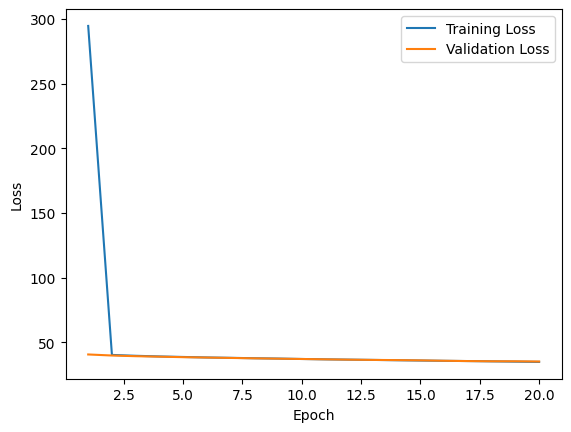

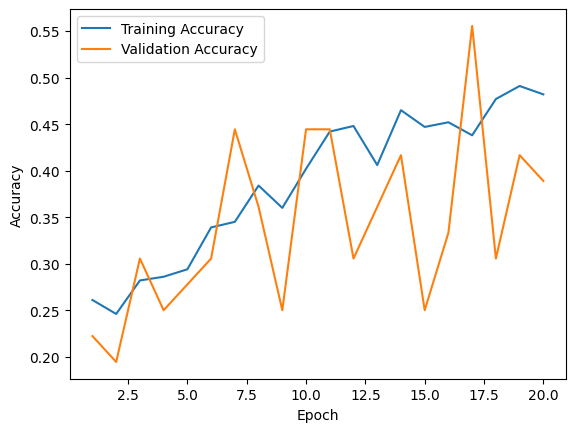

2/2 [==============================] - 0s 9ms/step - loss: 35.0268 - accuracy: 0.3889
Test accuracy: 31.58%
Validation accuracy: 38.89%


In [ ]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=lr, beta_1=0.9,
                                       beta_2=0.999)
history_adamax = build_and_train_model(optimizer, name="adammax")

# Accessing performance metrics from history
train_loss = history_adamax.history['loss']
val_loss = history_adamax.history['val_loss']
train_acc = history_adamax.history['accuracy']
val_acc = history_adamax.history['val_accuracy']

# Assuming you have the same number of epochs as in your training
epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model_adamx = keras.models.load_model("data/pet_models/adammax.keras")

# Evaluate the model on the test and validation datasets
test_loss, test_acc = model_adamx.evaluate(test_generator)
val_loss, val_acc = model_adamx.evaluate(valid_generator)
print(f"Test accuracy: {test_acc*100:.2f}%")
print(f"Validation accuracy: {val_acc*100:.2f}%")


##### Nadam Optimizer:

Epoch 1/20
32/32 [==============================] - 8s 223ms/step - loss: 366.9960 - accuracy: 0.2370 - val_loss: 42.1459 - val_accuracy: 0.2222
Epoch 2/20
32/32 [==============================] - 10s 314ms/step - loss: 41.4136 - accuracy: 0.2660 - val_loss: 40.4723 - val_accuracy: 0.2778
Epoch 3/20
32/32 [==============================] - 7s 222ms/step - loss: 39.6544 - accuracy: 0.2550 - val_loss: 38.8621 - val_accuracy: 0.2222
Epoch 4/20
32/32 [==============================] - 6s 198ms/step - loss: 38.1607 - accuracy: 0.2520 - val_loss: 37.4573 - val_accuracy: 0.2778
Epoch 5/20
32/32 [==============================] - 7s 218ms/step - loss: 36.8656 - accuracy: 0.2970 - val_loss: 36.2581 - val_accuracy: 0.2500
Epoch 6/20
32/32 [==============================] - 8s 240ms/step - loss: 35.9834 - accuracy: 0.3170 - val_loss: 35.1023 - val_accuracy: 0.3889
Epoch 7/20
32/32 [==============================] - 7s 229ms/step - loss: 35.8236 - accuracy: 0.3030 - val_loss: 34.4442 - val_accurac

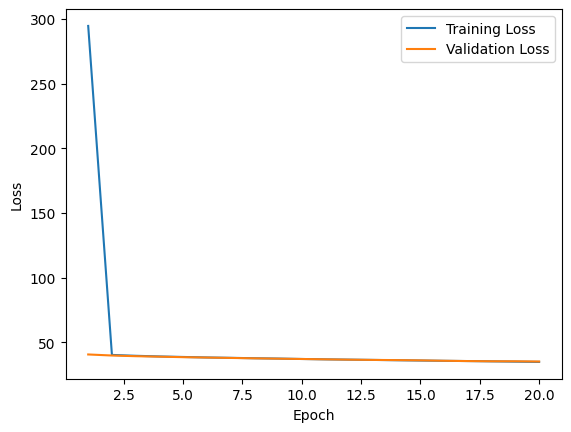

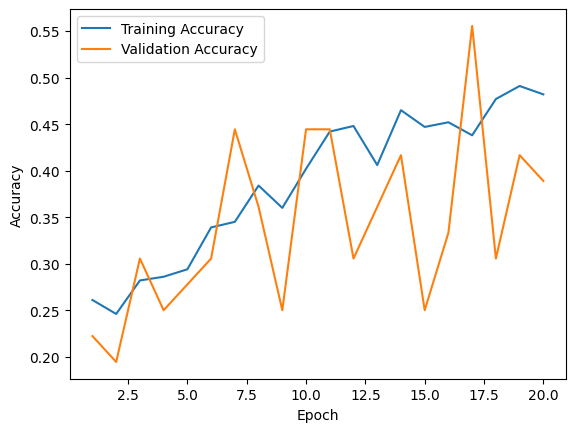

2/2 [==============================] - 0s 11ms/step - loss: 27.9069 - accuracy: 0.3611
Test accuracy: 31.58%
Validation accuracy: 36.11%


In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr, beta_1=0.9,
                                      beta_2=0.999)

history_nadam = build_and_train_model(optimizer, name ="nadam")

# Accessing performance metrics from history
train_loss = history_adamax.history['loss']
val_loss = history_adamax.history['val_loss']
train_acc = history_adamax.history['accuracy']
val_acc = history_adamax.history['val_accuracy']

# Assuming you have the same number of epochs as in your training
epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model_adamx = keras.models.load_model("data/pet_models/nadam.keras")

# Evaluate the model on the test and validation datasets
test_loss, test_acc = model_adamx.evaluate(test_generator)
val_loss, val_acc = model_adamx.evaluate(valid_generator)
print(f"Test accuracy: {test_acc*100:.2f}%")
print(f"Validation accuracy: {val_acc*100:.2f}%")

Adamax and Nadam Optimizers seems to have better learning curve and the accuracy for them on both test and validation set seems better so we will use oof them to creat a neural network again.

##### Utilizing the Adam Max optimizer for our model: 

In [12]:
from tensorflow.keras import regularizers
tf.random.set_seed(23)

model = Sequential()

# Convolutional and pooling layers
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(2, 2))

# Fully connected layers
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
# Output layer
model.add(Dense(4, activation='softmax'))


# model = build_simple_model()
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
keras.callbacks.ModelCheckpoint(
    filepath="data/pet_models/final.keras",
    save_best_only=True,
    monitor="val_loss")]

history = model.fit(train_generator,epochs=20,
          validation_data=valid_generator,
          callbacks = callbacks,verbose = 1)



Epoch 1/20
32/32 [==============================] - 7s 207ms/step - loss: 286.9274 - accuracy: 0.2350 - val_loss: 41.9599 - val_accuracy: 0.2500
Epoch 2/20
32/32 [==============================] - 6s 200ms/step - loss: 41.6641 - accuracy: 0.2700 - val_loss: 41.3328 - val_accuracy: 0.2222
Epoch 3/20
32/32 [==============================] - 7s 234ms/step - loss: 41.0608 - accuracy: 0.2960 - val_loss: 40.8335 - val_accuracy: 0.2500
Epoch 4/20
32/32 [==============================] - 7s 219ms/step - loss: 40.5924 - accuracy: 0.3130 - val_loss: 40.5761 - val_accuracy: 0.3056
Epoch 5/20
32/32 [==============================] - 7s 208ms/step - loss: 40.2145 - accuracy: 0.3070 - val_loss: 40.0209 - val_accuracy: 0.3889
Epoch 6/20
32/32 [==============================] - 7s 216ms/step - loss: 39.8409 - accuracy: 0.3530 - val_loss: 39.7348 - val_accuracy: 0.3056
Epoch 7/20
32/32 [==============================] - 6s 203ms/step - loss: 39.5069 - accuracy: 0.3520 - val_loss: 39.4838 - val_accuracy

##### Training Vs Validation Accuracy/Loss :

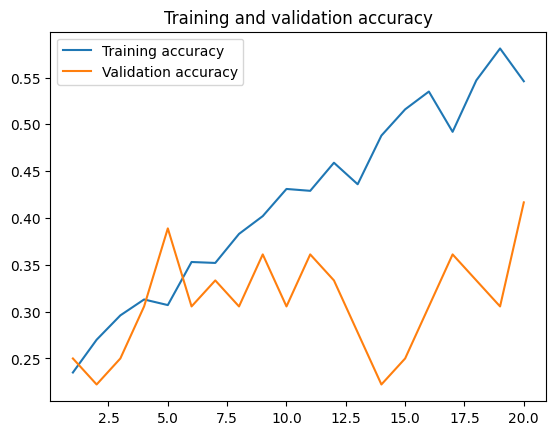

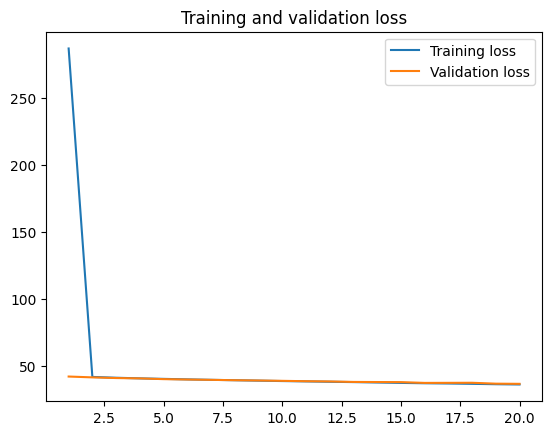

2/2 [==============================] - 0s 7ms/step - loss: 36.5100 - accuracy: 0.4167
Test accuracy: 42.11%
Validation accuracy: 41.67%


In [13]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss,  label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Evaluate the model on the test and validation datasets
test_loss, test_acc = model.evaluate(test_generator)
val_loss, val_acc = model.evaluate(valid_generator)
print(f"Test accuracy: {test_acc*100:.2f}%")
print(f"Validation accuracy: {val_acc*100:.2f}%")

##### Classification report:

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
y_pred = model.predict(test_generator)
y_predict =  np.argmax(y_pred, axis =1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true,y_predict)
class_report = classification_report(y_true, y_predict, target_names=test_generator.class_indices.keys())
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


2/2 [==============================] - 0s 16ms/step
Confusion Matrix:
 [[4 0 4 2]
 [1 3 2 0]
 [7 1 2 1]
 [4 3 2 2]]

Classification Report:
               precision    recall  f1-score   support

       Angry       0.25      0.40      0.31        10
       Other       0.43      0.50      0.46         6
         Sad       0.20      0.18      0.19        11
       happy       0.40      0.18      0.25        11

    accuracy                           0.29        38
   macro avg       0.32      0.32      0.30        38
weighted avg       0.31      0.29      0.28        38



As seen above using this optimizer resulted in a bit increase in accuracy on the dataset. But dues to the distribution of the images being of various animals such as cats, dogs, roosters, horse etc. the model has some difficulties in analyzing their emontion just using the CNN neural model.